## Load data

In [1]:
import os
import h5py
import numpy as np

DATA_DIR = 'data'

def load_dataset():
    train_dataset = h5py.File(os.path.join(DATA_DIR, 'train.h5'), 'r')
    X_train = np.array(train_dataset['X_train'])
    y_train = np.array(train_dataset['y_train'])

    val_dataset = h5py.File(os.path.join(DATA_DIR, 'val.h5'), 'r')
    X_val = np.array(val_dataset['X_val'])
    y_val = np.array(val_dataset['y_val'])

    labels = open(os.path.join(DATA_DIR, 'labels.txt')).read().split('\n')[:-1]
    
    return X_train, y_train, X_val, y_val, labels

X_train, y_train, X_val, y_val, labels = load_dataset()

Visualize a sample data

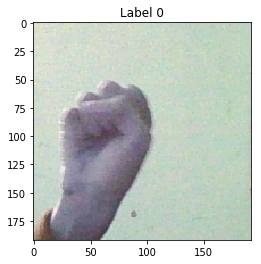

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

index = 0
plt.imshow(X_train[index])
plt.title('Label {}'.format(labels[y_train[index]]))

plt.show()

Examine shape of data

In [3]:
print("Train data:", X_train.shape)
print("Train labels:", y_train.shape)

print("Validation data:", X_val.shape)
print("Validation labels:", y_val.shape)

Train data: (1437, 192, 192, 3)
Train labels: (1437,)
Validation data: (360, 192, 192, 3)
Validation labels: (360,)


## Preprocess data

First we grascale all images. Test with 1 image:

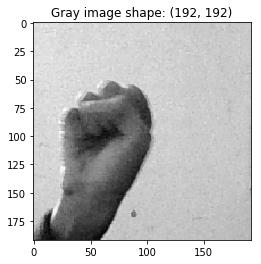

In [4]:
import cv2

image = X_train[0]
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap='gray')
plt.title('Gray image shape: {}'.format(gray_image.shape))
plt.show()

We also need rescale image for computational efficiency + remove complicated details

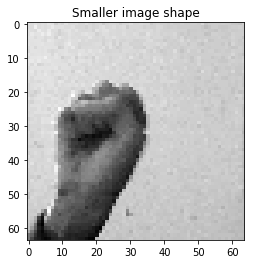

In [5]:
smaller_image = cv2.resize(gray_image, (64, 64))

plt.imshow(smaller_image, cmap='gray')
plt.title('Smaller image shape'.format(smaller_image.shape))
plt.show()

Now apply all above steps.
We can see that data is composed of [m, H, W, C], which:
+ m: Number of data
+ H, W: Picture's height & width
+ C: Number of channels
    
For Pytorch, we need [m, C, H, W] (C=1 for gray images)

In [6]:
from tqdm import tqdm

def grayscale(X):
    X_gray = []
    for i, image in tqdm(enumerate(X)):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        smaller = cv2.resize(gray, (64, 64))
        smaller_with_channel = np.reshape(smaller, (1, 64, 64))
        X_gray.append(smaller_with_channel)
        
    X_gray = np.array(X_gray)
    return X_gray
        
X_train = grayscale(X_train)
X_val = grayscale(X_val)

1437it [00:00, 12609.76it/s]
360it [00:00, 11400.75it/s]


Normalization: devide by 255

In [7]:
X_train = X_train / 255.
X_val = X_val / 255.

Examine data after preprocessing

In [8]:
print("Train data:", X_train.shape)
print("Train labels:", y_train.shape)

print("Validation data:", X_val.shape)
print("Validation labels:", y_val.shape)

Train data: (1437, 1, 64, 64)
Train labels: (1437,)
Validation data: (360, 1, 64, 64)
Validation labels: (360,)


## Make dataset/dataloader

Convert data to Pytorch's tensors

In [9]:
import torch

X_train_tensor = torch.from_numpy(X_train.astype('float32'))
y_train_tensor = torch.from_numpy(np.squeeze(y_train).astype('int'))

X_val_tensor = torch.from_numpy(X_val.astype('float32'))
y_val_tensor = torch.from_numpy(np.squeeze(y_val).astype('int'))

Make dataset from tensors

In [10]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

Test dataset maker

In [11]:
print("Length of dataset:", len(train_dataset))

X_sample, y_sample = train_dataset[0]
print("Sample X:", X_sample)
print("Sample y:", y_sample)

Length of dataset: 1437
Sample X: 
(0 ,.,.) = 
  0.8588  0.8431  0.8627  ...   0.7882  0.7804  0.8000
  0.8431  0.8431  0.8941  ...   0.8000  0.8078  0.8000
  0.8549  0.8431  0.8353  ...   0.7961  0.8000  0.8000
           ...             ⋱             ...          
  0.7020  0.5765  0.4431  ...   0.7490  0.7490  0.7451
  0.5647  0.5137  0.3922  ...   0.7412  0.7608  0.7529
  0.5608  0.4392  0.3490  ...   0.7529  0.7451  0.7412
[torch.FloatTensor of size 1x64x64]

Sample y: 0


Make dataloader (input pipeline)

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

## Build model

Basic CNN

In [13]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32*13*13, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, len(labels)),
            nn.Dropout(p=0.5)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # flatten [m, C, H, W] -> [m, C*H*W]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [14]:
model = CNN()
model = model.cuda() # use GPU
print(model)

CNN (
  (layer1): Sequential (
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc1): Sequential (
    (0): Linear (5408 -> 1024)
    (1): ReLU ()
    (2): Dropout (p = 0.5)
  )
  (fc2): Sequential (
    (0): Linear (1024 -> 6)
    (1): Dropout (p = 0.5)
  )
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Train

Prepare checkpoint for saving best model (`val_acc` monitoring)

In [16]:
MODEL_DIR = 'model'
MODEL_PATH = os.path.join(MODEL_DIR, 'cnn.pth')

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

In [17]:
from torch.autograd import Variable

def fit(epochs):
    history = {
        'loss': [],
        'val_acc': [],
        'best_val_acc': 0.0
    }
    
    def train(epoch):
        model.train()

        ITERATIONS = len(train_dataset) // BATCH_SIZE + 1
        for i, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.cuda(), target.cuda() # use GPU

            ## forward 
            output = model(data)

            ## compute loss
            loss = criterion(output, target)

            ## bacwward and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ## Regularly check
            if (i+1) % 3 == 0:
                print("({}) [{}/{}] loss: {:.4f}".format(epoch+1, i+1, ITERATIONS,
                                                         loss.data[0]))

        ## save training loss
        history['loss'].append(loss.data[0])


    def validate():
        model.eval()

        total = len(val_dataset)
        correct = 0
        for data, target in val_loader:
            data, target = Variable(data, volatile=True), Variable(target)
            data, target = data.cuda(), target.cuda() # use GPU

            # forward
            output = model(data)

            # get index of the max
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum() # check equality, then sum up

        val_acc = correct/total
        print("val_acc: {:.2f}".format(correct/total))
        
        # Checkpoint for saving best model
        if val_acc > history['best_val_acc']:
            history['best_val_acc'] = val_acc
            torch.save(model.state_dict(), MODEL_PATH)
        
        # Save validation accuracy
        history['val_acc'].append(val_acc)        

    ## Start training, validate accuracy each epoch
    for epoch in range(0, epochs):
        train(epoch)
        validate()
    
    return history

In [18]:
EPOCHS = 20
history = fit(EPOCHS)

(1) [3/12] loss: 3.4541
(1) [6/12] loss: 1.7648
(1) [9/12] loss: 1.5088
(1) [12/12] loss: 1.3510
val_acc: 0.16
(2) [3/12] loss: 1.1071
(2) [6/12] loss: 0.8316
(2) [9/12] loss: 0.9523
(2) [12/12] loss: 0.7928
val_acc: 0.16
(3) [3/12] loss: 0.8713
(3) [6/12] loss: 0.7812
(3) [9/12] loss: 0.8135
(3) [12/12] loss: 0.7966
val_acc: 0.23
(4) [3/12] loss: 0.6995
(4) [6/12] loss: 0.7483
(4) [9/12] loss: 0.6977
(4) [12/12] loss: 0.5615
val_acc: 0.83
(5) [3/12] loss: 0.6640
(5) [6/12] loss: 0.7290
(5) [9/12] loss: 0.6303
(5) [12/12] loss: 0.7461
val_acc: 0.87
(6) [3/12] loss: 0.7822
(6) [6/12] loss: 0.6993
(6) [9/12] loss: 0.7341
(6) [12/12] loss: 0.6460
val_acc: 0.91
(7) [3/12] loss: 0.5719
(7) [6/12] loss: 0.6415
(7) [9/12] loss: 0.7054
(7) [12/12] loss: 0.8731
val_acc: 0.88
(8) [3/12] loss: 0.6152
(8) [6/12] loss: 0.6117
(8) [9/12] loss: 0.7691
(8) [12/12] loss: 0.7189
val_acc: 0.88
(9) [3/12] loss: 0.6490
(9) [6/12] loss: 0.6357
(9) [9/12] loss: 0.6457
(9) [12/12] loss: 0.7246
val_acc: 0.93
(

Visualize training process

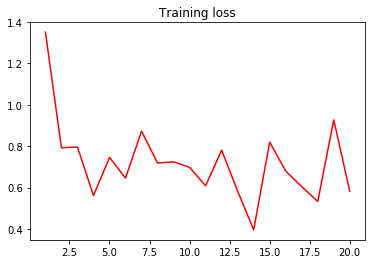

In [19]:
epochs = range(1, EPOCHS+1)

plt.plot(epochs, history['loss'], 'r')
plt.title('Training loss')
plt.show()

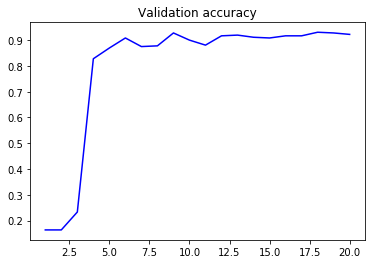

In [20]:
plt.plot(epochs, history['val_acc'], 'b')
plt.title('Validation accuracy')
plt.show()

## Test

Load best model checkpoints

In [21]:
model.load_state_dict(torch.load(MODEL_PATH))
print("Best val_acc",history['best_val_acc'])

Best val_acc 0.9305555555555556


In [22]:
def predict(X):
    """Arguments
        X: numpy image, shape (H, W, C)
    """
    # gray
    X = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
    # rescale
    X = cv2.resize(X, (64, 64))
    # normalize
    X = X / 255.
    # reshape
    X = np.reshape(X, (1, 1, 64, 64))
    
    X = torch.from_numpy(X.astype('float32'))
    X = Variable(X, volatile=True)
    
    # forward
    output = model.cpu()(X)

    # get index of the max
    _, index = output.data.max(1, keepdim=True)
    return labels[index[0][0]] # index is a LongTensor -> need to get int data

Sample predict from validation data

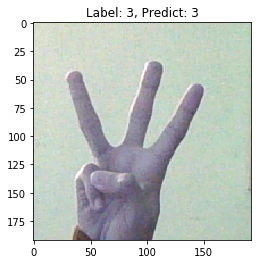

In [24]:
import random

_, _, X_val, y_val, labels = load_dataset()
index = random.randint(0, len(X_val))

pred = predict(X_val[index])

plt.imshow(X_val[index])
plt.title('Label: {}, Predict: {}'.format(labels[y_val[index]], pred))
plt.show()